In [1]:
from deeplab3.dataloaders.datasets.coco import COCOSegmentation
from deeplab3.dataloaders import custom_transforms as tr
from deeplab3.dataloaders.utils import decode_segmap
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import math

from types import SimpleNamespace

Loading RGB-D and segmentation
-------

The depth and RGB are saved as seperate jpg files. Each is loaded seperately, then they are concatenated into a 4-channel image with the depth channel takeing the place of an alpha channel. All four channels are normalized and a random crop, horizontal flip, and gaussian blur are applied for image augmentation. The same transformation are applied to the segmentation mask.

Let's start by looking at a batch of 4 images and segmentation masks.

In [2]:
from deeplab3.config.defaults import get_cfg_defaults
cfg = get_cfg_defaults()
cfg.merge_from_file('../configs/low-light/coco_rgbd_pascal_low_light.yaml')
cfg.merge_from_list(['DATASET.ROOT', '../datasets/coco/'])

In [3]:
#Same as main method of dataloaders.datasets.coco
city_val = COCOSegmentation(cfg, split='train')

dataloader = DataLoader(city_val, batch_size=1, shuffle=True, num_workers=0)

loading annotations into memory...
Done (t=19.07s)
creating index...
index created!
Using RGB-D input


In [4]:
def display_grid(images, labels):
    
    n = len(labels)
    plt.figure(figsize=(16, 8))
    
    m = math.ceil(n/4)
    for ii in range(n):
        if images[ii] is not None:
            plt.subplot('{}4{}'.format(m, ii+1))
            plt.imshow(images[ii])
            plt.title(labels[ii])
            plt.axis('off')

AssertionError: ../datasets/coco/VNL_Monocular/000000025525.png

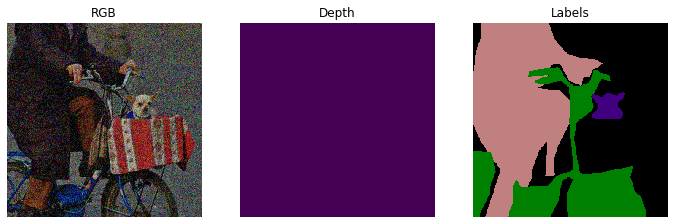

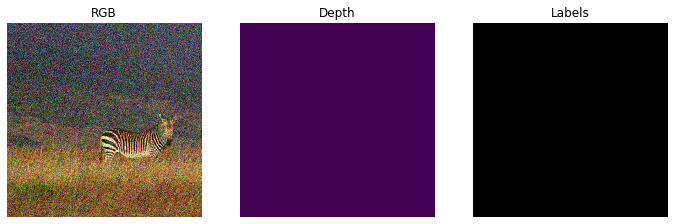

In [5]:
for ii, sample in enumerate(dataloader):
    for jj in range(sample["image"].size()[0]):
        img_tmp = city_val.loader.invert_normalization(sample['image'].squeeze())
        gt = sample['label'].numpy()
        tmp = np.array(gt[jj]).astype(np.uint8)
        segmap = decode_segmap(tmp, dataset='coco')
        
        imgs = [img_tmp[:,:,:3], img_tmp[:,:,3:].squeeze(), segmap]
        labels = ['RGB', 'Depth', 'Labels']
        display_grid(imgs, labels)

    if ii == 10:
        break

plt.show(block=True)

Load a saved model and visualize results
-----

The trained model takes the RGB-D image as input and produces a segmentation mask

In [ ]:
import torch
import os
from deeplab3.dataloaders import make_data_loader
from deeplab3.modeling.sync_batchnorm.replicate import patch_replication_callback
from deeplab3.modeling.deeplab import *

In [ ]:
## Load saved model
def load_model(cfg):
    model = DeepLab(cfg)

    if cfg.SYSTEM.CUDA:
        model = torch.nn.DataParallel(model, device_ids=cfg.SYSTEM.GPU_IDS)
        patch_replication_callback(model)
        model = model.cuda()

    if not os.path.isfile(cfg.TRAIN.RESUME):
        raise RuntimeError("=> no checkpoint found at '{}'" .format(cfg.TRAIN.RESUME))
    checkpoint = torch.load(cfg.TRAIN.RESUME)
    cfg.TRAIN.START_EPOCH = checkpoint['epoch']
    if cfg.SYSTEM.CUDA:
        model.module.load_state_dict(checkpoint['state_dict'])
    else:
        model.load_state_dict(checkpoint['state_dict'])
    best_pred = checkpoint['best_pred']
    print("=> loaded checkpoint '{}' (epoch {})"
          .format(cfg.TRAIN.RESUME, checkpoint['epoch']))
    return model

In [ ]:
from deeplab3.config.defaults import get_cfg_defaults
cfg_rgbd = get_cfg_defaults()
cfg_rgbd.merge_from_file("configs/coco_rgbd.yaml")
cfg_rgbd.merge_from_list(['TRAIN.RESUME', 'run/coco/coco_rgbd_resnet_deeplab/experiment_6/checkpoint.pth.tar',
                         ])

cfg_rgb = get_cfg_defaults()
#cfg_rgb.merge_from_file("")
cfg_rgb.merge_from_list(['TRAIN.RESUME', 'pretrained/deeplab-resnet.pth',
                        'DATASET.USE_DEPTH', False,
                        'DATASET.CHANNELS', 3,
                        'DATASET.N_CLASSES', 21])

rgbd_model = load_model(cfg_rgbd)
rgb_model = load_model(cfg_rgb)

rgbd_model.eval()
rgb_model.eval()

In [ ]:
def inverse_normalize(image):
    data_std = dataloader.dataset.data_std
    data_mean = dataloader.dataset.data_mean
    
    channels = image.shape[2]
    for ii in range(channels):
        image[:,:, ii] = image[:,:, ii]*data_std[ii]
        image[:,:, ii] = image[:,:, ii]+data_mean[ii]
        
    return image

def display_results(image, target):
    if cfg_rgbd.SYSTEM.CUDA:
        image, target = image.cuda(), target.cuda()
    with torch.no_grad():
        output_rgbd = rgbd_model(image)
        output_rgb = rgb_model(image[:, 0:3, :, :])
    #loss = criterion(output, target)
    
    image = image.cpu().numpy()
    target = target.cpu().numpy()
    
    pred_rgbd = output_rgbd.data.cpu().numpy()
    pred_rgbd = np.argmax(pred_rgbd, axis=1)
    
    pred_rgb = output_rgb.data.cpu().numpy()
    pred_rgb = np.argmax(pred_rgb, axis=1)
    
    for jj in range(sample["image"].size()[0]):
        img_tmp = np.transpose(image[jj], axes=[1, 2, 0])
        img_tmp = inverse_normalize(img_tmp)
        
        segmap = decode_segmap(target[jj], dataset='coco')
        segmap_rgbd = decode_segmap(pred_rgbd[jj], dataset='coco')
        segmap_rgb = decode_segmap(pred_rgb[jj], dataset='coco')
        
        plt.figure(figsize=(16, 4))
        plt.subplot(151)
        plt.imshow(img_tmp[:,:,:3])
        plt.title('RGB')
        plt.axis('off')
        
        plt.subplot(152)
        plt.imshow(img_tmp[:,:,3])
        plt.title('Depth')
        plt.axis('off')
        
        plt.subplot(153)
        plt.imshow(segmap) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
        plt.title('GT')
        plt.axis('off')
        
        plt.subplot(154)
        plt.imshow(segmap_rgbd) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
        plt.title('RGBD')
        plt.axis('off')
        
        plt.subplot(155)
        plt.imshow(segmap_rgb) #, cmap='tab20b', vmin=0, vmax=dataloader.dataset.NUM_CLASSES)
        plt.title('RGB')
        plt.axis('off')


In [ ]:
from deeplab3.dataloaders.utils import get_pascal_labels

#Class colors for reference
labels = ['unknown']
labels.extend([x['name'] for x in dataloader.dataset.coco.loadCats(dataloader.dataset.CAT_LIST[1:])])

plt.figure(figsize=(16, 1))
plt.imshow(np.expand_dims(get_pascal_labels(), 0))
plt.xticks(range(81), labels, rotation=45)
print(labels)

# Test images 

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    display_results(image, target)
    break

plt.show(block=True)


Convolutional Filter Visualization
--------

Code modified from https://colab.research.google.com/github/Niranjankumar-c/DeepLearning-PadhAI/blob/master/DeepLearning_Materials/6_VisualizationCNN_Pytorch/CNNVisualisation.ipynb

In [ ]:
def sub2ind(array_shape, rows, cols):
    return rows*array_shape[1] + cols + 1

def plot_filters_single_channel(t, fig):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 4
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i) + ',' + str(j))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])

def plot_filters_multi_channel(t, fig, num_cols=2, current_col=0):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #rows = num of kernels
    num_rows = num_kernels

    #looping through all the kernels
    for i in range(t.shape[0]):
#         if i == 0:
#             print(t[i])
        ind = sub2ind((num_rows, num_cols), i, current_col)
        ax1 = fig.add_subplot(num_rows,num_cols,ind)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        #TODO Is this normalization the correct way of visualizing? 
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        if len(t.shape) == 4:
            npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])   
    
def plot_weights(layer):
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data.cpu()
    
    #set the figure size
    num_cols = 2
    num_rows = weight_tensor.shape[0]
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    plot_filters_multi_channel(weight_tensor[:,:3, :, :], fig)
    plot_filters_multi_channel(weight_tensor[:, 3, :, :], fig, current_col=1)
        
  else:
    print("Can only visualize layers which are convolutional")                          
  
  plt.tight_layout()
  plt.show()

In [ ]:
#visualize weights for model - first conv layer
plot_weights(rgbd_model.module.backbone.conv1)


Depth Ablation Study
-----

In [ ]:
dataloader = DataLoader(coco_val, batch_size=1, shuffle=True, num_workers=0)

for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
#     image = image[0, :, :, :].unsqueeze(0)
#     target = target[0, :, :]
    
    # Full RGBD
    display_results(image, target)
    
    # No depth
    rgb_image = image.clone()
    rgb_image[:, 3, :, :] = 0
    display_results(rgb_image, target)
    
    # No red channel 
    gbd_image = image.clone()
    gbd_image[:, 0, :, :] = 0
    display_results(gbd_image, target)
    
     # No blue channel 
    rgd_image = image.clone()
    rgd_image[:, 2, :, :] = 0
    display_results(rgd_image, target)
    
     # No green channel 
    rbd_image = image.clone()
    rbd_image[:, 1, :, :] = 0
    display_results(rbd_image, target)

    break

plt.show(block=True)

In [ ]:
# Depth Only
for ii, sample in enumerate(dataloader):
    image, target = sample['image'], sample['label']
    image[:, 0:3, :, :] = 0
    display_results(image, target)

    break

plt.show(block=True)

Loss Comparison
----


In [ ]:
from deeplab3.utils.loss import SegmentationLosses
from deeplab3.utils.metrics import Evaluator
from tqdm import tqdm_notebook

def evaluation(model_name, model, dataloader, loss_type='ce', class_weights=None):
    criterion = SegmentationLosses(weight=class_weights, cuda=model.cuda).build_loss(mode=loss_type)
    evaluator = Evaluator(dataloader.dataset.NUM_CLASSES)
    
    model.eval()
    evaluator.reset()
    tbar = tqdm_notebook(dataloader, desc='\r')
    test_loss = 0.0
    for i, sample in enumerate(tbar):
        image, target = sample['image'], sample['label']
        if model.cuda:
            image, target = image.cuda(), target.cuda()
        with torch.no_grad():
            output = model(image)
        loss = criterion(output, target)
        test_loss += loss.item()
        tbar.set_description('Test loss: %.3f' % (test_loss / (i + 1)))
        pred = output.data.cpu().numpy()
        target = target.cpu().numpy()
        pred = np.argmax(pred, axis=1)
        # Add batch sample into evaluator
        evaluator.add_batch(target, pred)

    # Fast test during the training
    Acc = evaluator.Pixel_Accuracy()
    Acc_class = evaluator.Pixel_Accuracy_Class()
    mIoU = evaluator.Mean_Intersection_over_Union()
    FWIoU = evaluator.Frequency_Weighted_Intersection_over_Union()
    
    print('{}:'.format(model_name))
    print("Acc:{}, Acc_class:{}, mIoU:{}, fwIoU: {}".format(Acc, Acc_class, mIoU, FWIoU))
    print('Loss: %.3f' % test_loss)

In [ ]:
dataloader = DataLoader(coco_val, batch_size=4, shuffle=True, num_workers=0)
evaluation('RGBD', rgbd_model, dataloader)

In [ ]:
coco_val_rgb = COCOSegmentation(args, split='val', year='2017', use_depth=False)
dataloader_rgb = DataLoader(coco_val_rgb, batch_size=4, shuffle=True, num_workers=0)
evaluation('RGB', rgb_model, dataloader_rgb)

In [ ]:
print(cfg_rgbd)

In [ ]:
print(cfg_rgb)